# This notebook is analzying the spectral parameters from the frontal EEG channels pre and post ECT.

We are only including frontal because we are basing our analyses off of Smith, 2022, in which their dataset only uses fronto-central channels. Additionally, the treatment is targeted to frontal/central areas.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
from statsmodels.formula.api import ols
from scipy.stats import ttest_rel
from pingouin import ttest, normality, wilcoxon

from ect_plotting_functions import plot_feature_prepost
from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
%matplotlib inline

### Functions

In [3]:
def perm_test(df, feature='', nreps=100000, seed=256, plot_hist=True, run_ttest=True):
    '''permutation test from https://www.uvm.edu/\~statdhtx/StatPages/\
    ResamplingWithR/RandomMatchedSample/RandomMatchedSampleR.html
    '''
    
    means_pre = df[df['pre_post']=='pre'][feature].values
    means_post = df[df['pre_post']=='post'][feature].values
    
    diff_obt = np.nanmedian(means_post) - np.nanmedian(means_pre)
    difference = means_post-means_pre
    
    np.random.seed(seed)
    resamp_mean_diff = np.zeros(nreps)

    for i in range(0, nreps):
        signs = np.random.choice([1, -1], len(difference), replace=True)
        resamp = difference * signs
        resamp_mean_diff[i] = np.nanmedian(resamp)

    diff_obt = abs(diff_obt)
    highprob = len(resamp_mean_diff[resamp_mean_diff >= diff_obt])/nreps
    lowprob = len(resamp_mean_diff[resamp_mean_diff <= -diff_obt])/nreps
    prob2tailed = lowprob + highprob

    print("The probability from the sampling statistics is = ",prob2tailed,'\n')

    if plot_hist:
        plt.hist(resamp_mean_diff, bins=30);
        plt.title(feature)
        plt.xlabel('Median Difference')
        plt.axvline(x=diff_obt, c='r')
        plt.axvline(x=-diff_obt, c='r')

    # compare to student's t-test
    if run_ttest:
        print(ttest(means_pre, means_post, paired=True))

In [4]:
FRONTAL_ONLY = False

In [5]:
# load dataframe
exp_df = pd.read_csv('../saved_files_appeal/ect_files/ect_all_features.csv', index_col = 0)
# Exclude channels flagged as bad fits
exp_df_included = exp_df[exp_df['exclude']==False]

In [6]:
# frontal_channels = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
#                     'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2',
#                     'FC4', 'FC6', 'FT8', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6']
frontal_channels = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
                    'F2', 'F4', 'F6', 'F8', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2',
                    'FC4', 'FC6']


if FRONTAL_ONLY:
    exp_df_included = exp_df_included[exp_df_included['channel'].isin(frontal_channels)]
else:
    exp_df_included = exp_df

## Load SpecParam Fits

In [7]:
fits_pre = np.load('../saved_files_appeal/ect_files/fits_pre.npy')
fits_post = np.load('../saved_files_appeal/ect_files/fits_post.npy')
freq_axis = np.load('../saved_files_appeal/ect_files/freq_axis.npy')

**Correct for excluded fits**

In [8]:
# get boolean area with True to exclude channels from patients
to_exclude_pre = exp_df['exclude'][exp_df['pre_post']=='pre'].values
to_exclude_post = exp_df['exclude'][exp_df['pre_post']=='post'].values

# reshape fits array from [23, 60,99] --> [1390, 99]
fits_pre_flat = fits_pre.reshape(len(to_exclude_pre), fits_pre.shape[2])
fits_post_flat = fits_post.reshape(len(to_exclude_pre), fits_pre.shape[2])

# replace to excluded ones with nans
fits_pre_flat[to_exclude_pre] = np.nan
fits_post_flat[to_exclude_post] = np.nan

# reshape back to original array from  [1390, 99] --> [23, 60,99]
fits_pre_included = fits_pre_flat.reshape(fits_pre.shape[0], fits_pre.shape[1], fits_pre.shape[2])
fits_post_included = fits_post_flat.reshape(fits_pre.shape[0], fits_pre.shape[1], fits_pre.shape[2])

## Load PSD's

In [9]:
psd_pre = np.load('../saved_files_appeal/ect_files/pre_ect_psd.npy')
psd_post = np.load('../saved_files_appeal/ect_files/post_ect_psd.npy')

**Correct for excluded PSD's**

In [10]:
# reshape psd array from [23, 60,99] --> [1390, 99]
psd_pre_flat = psd_pre.reshape(len(to_exclude_pre), psd_pre.shape[2])
psd_post_flat = psd_post.reshape(len(to_exclude_pre), psd_pre.shape[2])

# replace to excluded ones with nans
psd_pre_flat[to_exclude_pre] = np.nan
psd_post_flat[to_exclude_post] = np.nan

# reshape back to original array from  [1390, 99] --> [23, 60,99]
psd_pre_included = psd_pre_flat.reshape(psd_pre.shape[0], psd_pre.shape[1], psd_pre.shape[2])
psd_post_included = psd_post_flat.reshape(psd_pre.shape[0], psd_pre.shape[1], psd_pre.shape[2])

### Replace NaN's with 0's for oscillatory amplitude (aperiodic adjusted)

There are so few delta oscillations, that we cannot run statistics (later on) using delta_amp. Therefore, we want to put a value instead of a NaN, and say that no oscillation = 0 mV. 

We may not end up using this no nan dataframe, and simply use permutation testing instead, but keeping this here just in case.

In [11]:
df_include_nonan = exp_df_included.copy()
df_include_nonan['delta_amp'] = df_include_nonan['delta_amp'].fillna(0)
df_include_nonan['theta_amp'] = df_include_nonan['theta_amp'].fillna(0)
df_include_nonan['alpha_amp'] = df_include_nonan['alpha_amp'].fillna(0)
df_include_nonan

,patient,pre_post,channel,delta_cf,delta_bw,delta_amp,delta_bp,theta_cf,theta_bw,theta_amp,theta_bp,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent,error,r_squared,exclude
0,2,pre,FP1,NaN,NaN,0.000000,-12.163904,NaN,NaN,0.000000,-12.963292,8.753634,1.477347,1.128229,-12.246069,-12.223400,0.544792,0.187824,0.619947,True
1,2,pre,FPZ,NaN,NaN,0.000000,-11.898514,NaN,NaN,0.000000,-12.804520,8.870313,1.740532,1.168099,-12.158889,-11.773319,1.047170,0.116802,0.886453,True
2,2,pre,FP2,NaN,NaN,0.000000,-12.491238,NaN,NaN,0.000000,-12.909546,9.179746,2.318619,1.015724,-12.133547,-12.435301,0.347079,0.102407,0.788447,True
3,2,pre,AF3,NaN,NaN,0.000000,-12.397279,NaN,NaN,0.000000,-12.971390,9.131372,2.397756,1.257181,-12.027771,-12.272316,0.645194,0.100321,0.892881,True
4,2,pre,AF4,NaN,NaN,0.000000,-12.153451,NaN,NaN,0.000000,-12.628600,8.501796,1.324216,1.118146,-11.860836,-12.160392,0.283251,0.112454,0.711893,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755,55,post,PO6,2.553998,1.0,0.929427,-10.025173,5.050188,2.393840,0.906087,-10.488895,8.863919,1.844095,1.337793,-10.768737,-9.895581,1.948355,0.054988,0.995060,False
2756,55,post,PO8,2.569041,1.0,0.928161,-9.978571,5.097560,2.418158,0.944726,-10.431467,8.884905,2.130652,1.246806,-10.807347,-9.840422,1.973506,0.053256,0.995397,False
2757,55,post,O1,2.552898,1.0,0.873010,-10.044384,4.996738,2.143285,0.928408,-10.464177,8.783556,2.447756,1.084474,-10.882132,-9.898193,1.863237,0.070752,0.991415,False
2758,55,post,OZ,2.523769,1.0,0.875591,-10.084470,5.088168,2.412697,0.990874,-10.494461,8.749089,1.844382,1.053671,-11.083623,-9.911188,2.021213,0.056417,0.994520,False


## Averaging Over All (*Frontal*) Electrodes Per Subject

**Average over with amplitudes as 0 (i.e. exp_df_mean_nonan)**

In [12]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_bw', 'alpha_cf']
exp_df_mean_nonan = pd.DataFrame(df_include_nonan.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

**Average over with NaNs (i.e. exp_df_mean)**

In [13]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_bw', 'alpha_cf']
exp_df_mean = pd.DataFrame(exp_df_included.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

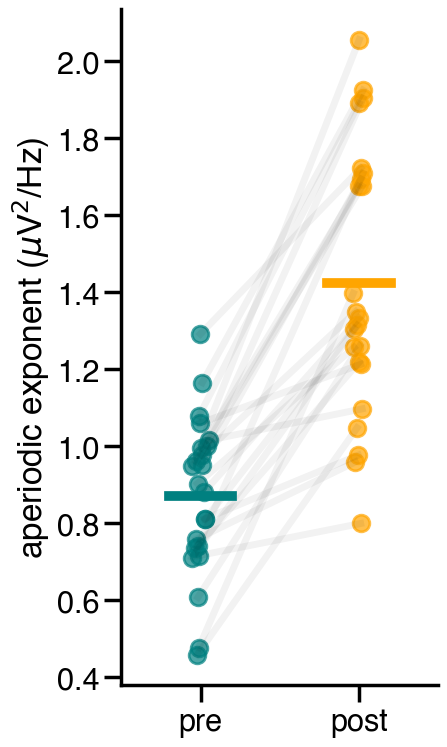

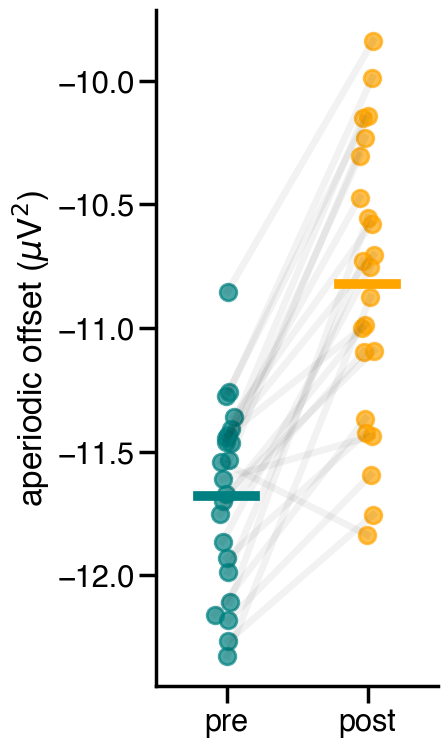

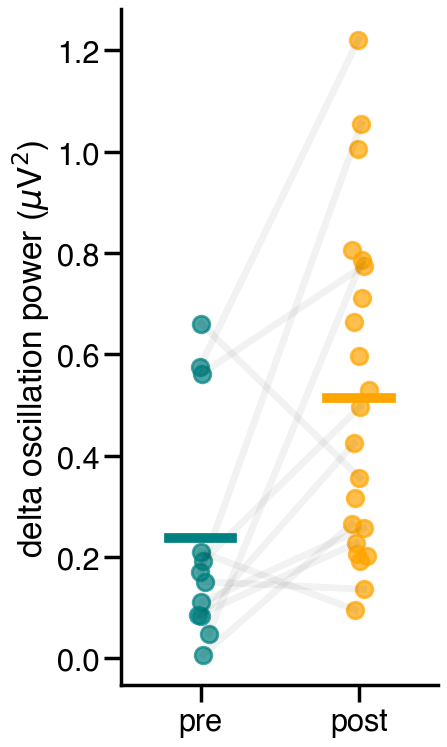

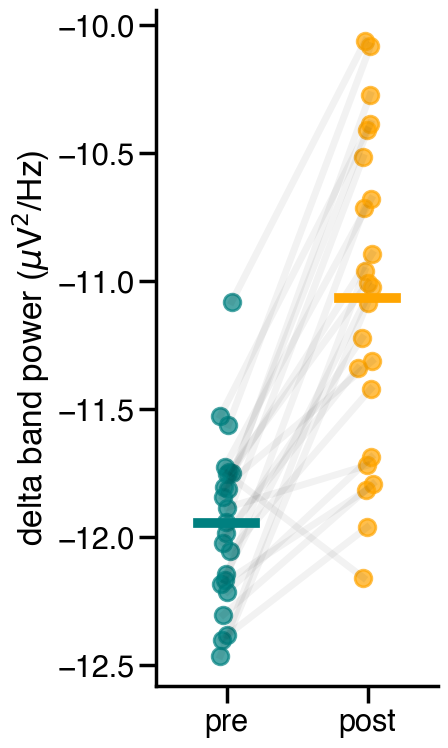

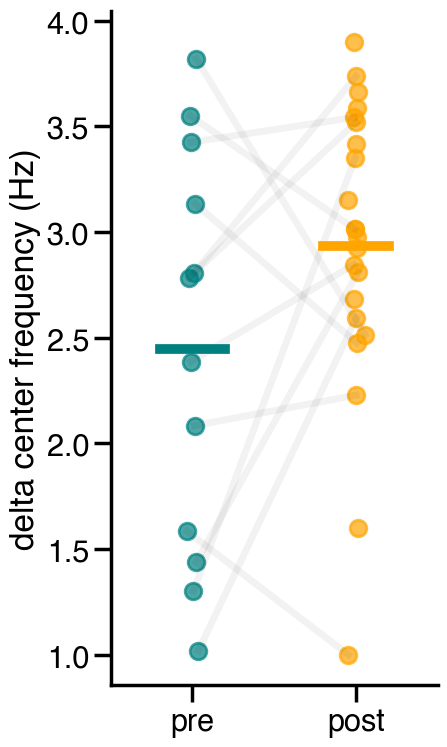

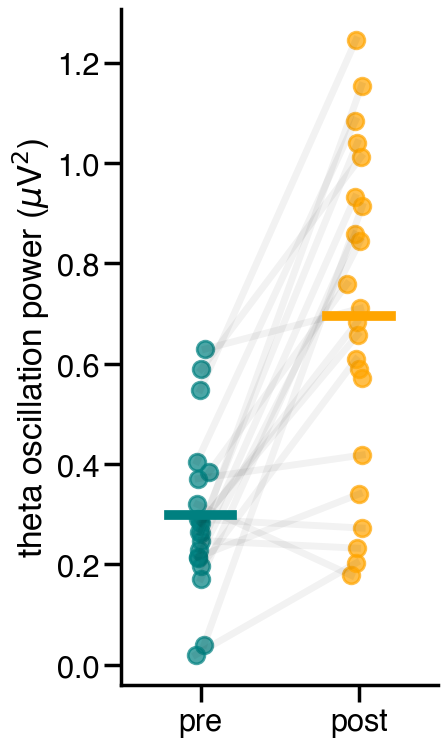

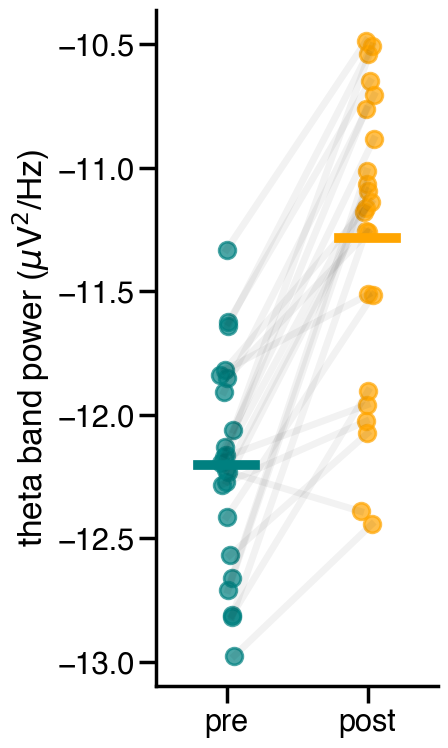

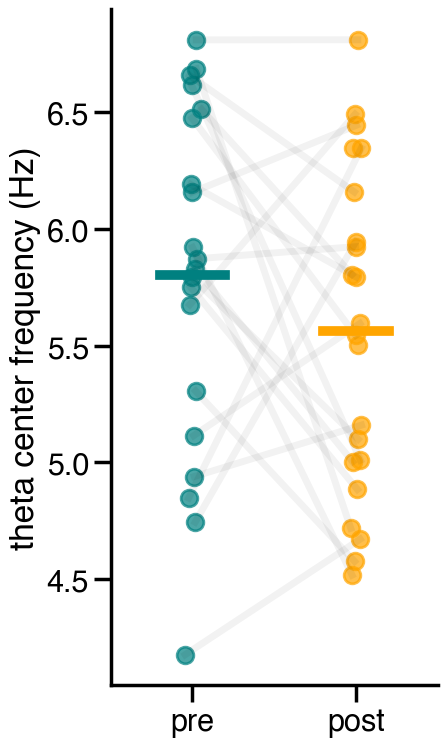

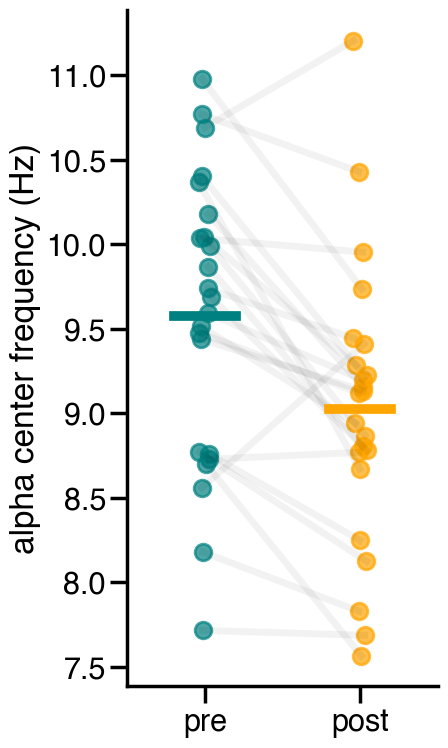

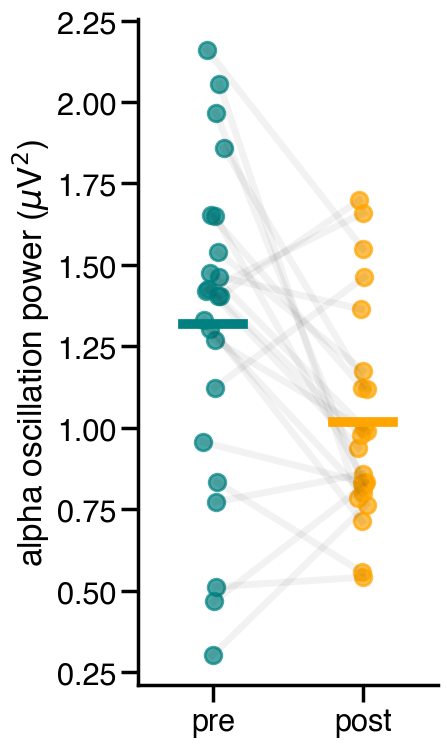

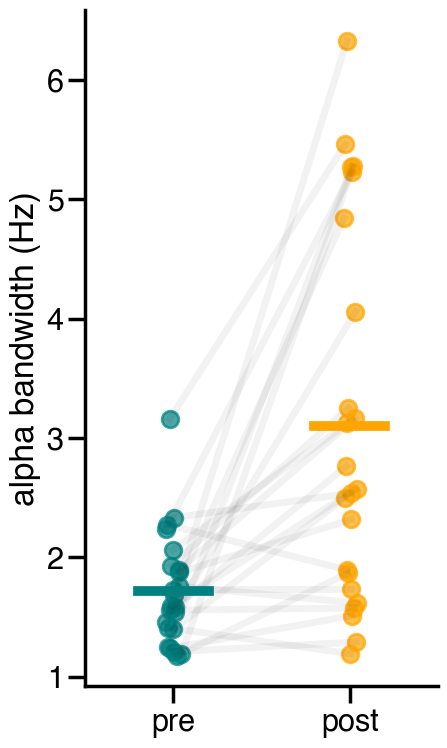

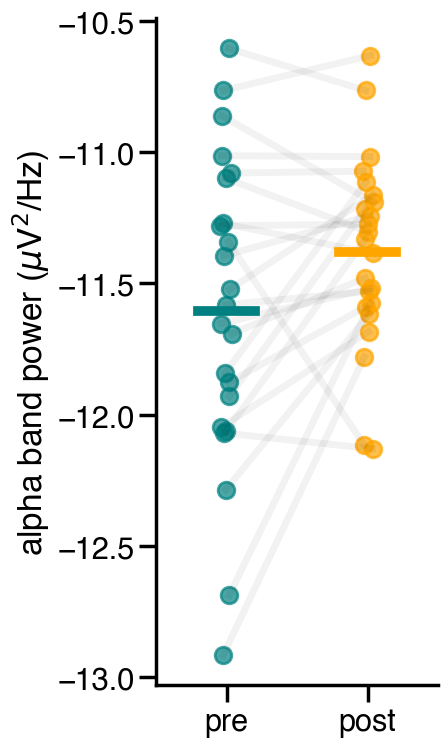

In [14]:
SAVE_FIG = False
fig_path = '../figures/'

# %matplotlib qt

features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'delta_cf', 'theta_amp', 'theta_bp', 'theta_cf',
            'alpha_cf', 'alpha_amp', 'alpha_bw', 'alpha_bp']

labels = ['aperiodic exponent ($\mu$V$^2$/Hz)', 'aperiodic offset ($\mu$V$^2$)',
          'delta oscillation power ($\mu$V$^2$)', 'delta band power ($\mu$V$^2$/Hz)', 'delta center frequency (Hz)',
          'theta oscillation power ($\mu$V$^2$)', 'theta band power ($\mu$V$^2$/Hz)', 'theta center frequency (Hz)',
          'alpha center frequency (Hz)', 'alpha oscillation power ($\mu$V$^2$)',
          'alpha bandwidth (Hz)', 'alpha band power ($\mu$V$^2$/Hz)' ]



for feature, label in zip(features, labels):
    plot_feature_prepost(exp_df_mean, feature=feature)
    plt.ylabel(label)
    plt.tight_layout()
    sns.despine()
    plt.show()
    
    if SAVE_FIG:
        plt.savefig(fig_path+feature+'.pdf', format='pdf')

### Figure-Specific Axes

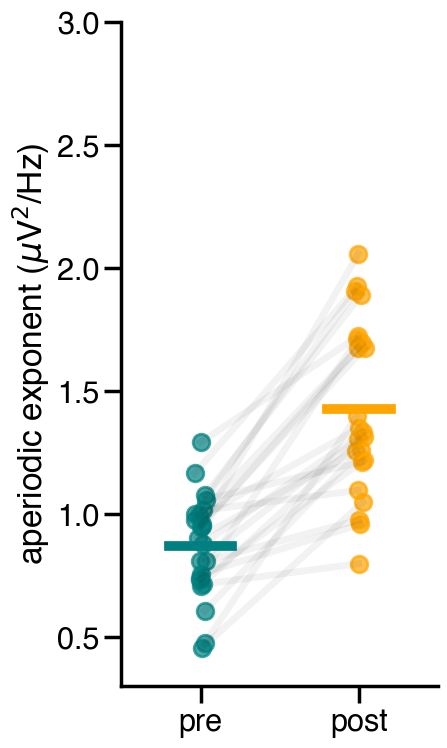

In [15]:
plot_feature_prepost(exp_df_mean, feature='exponent')
plt.ylabel('aperiodic exponent ($\mu$V$^2$/Hz)')
plt.ylim(0.3, 3.0)
sns.despine()
plt.tight_layout()
plt.show()

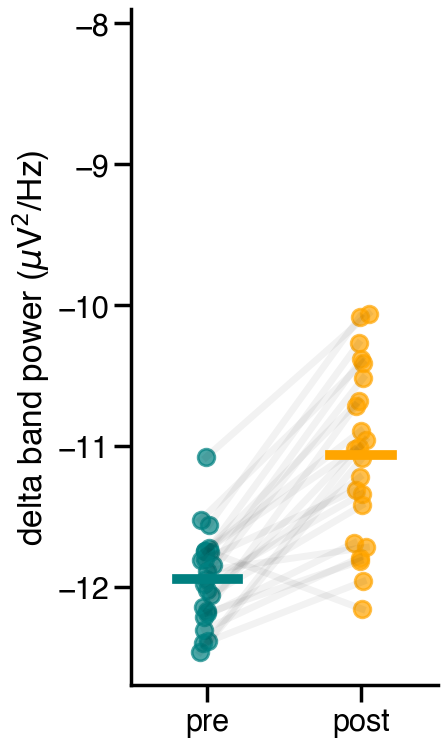

In [16]:
plot_feature_prepost(exp_df_mean, feature='delta_bp')
plt.ylabel('delta band power ($\mu$V$^2$/Hz)')
plt.ylim(-12.7, -7.9)
sns.despine()
plt.tight_layout()
plt.show()

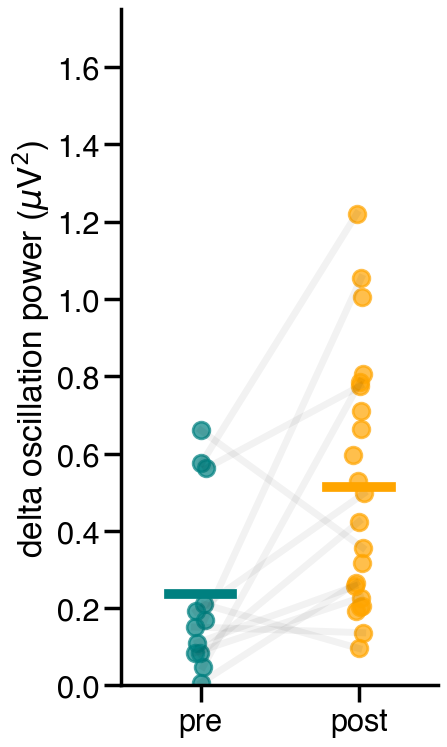

In [17]:
plot_feature_prepost(exp_df_mean, feature='delta_amp')
plt.ylabel('delta oscillation power ($\mu$V$^2$)')
plt.ylim(0, 1.75)
sns.despine()
plt.tight_layout()
plt.show()

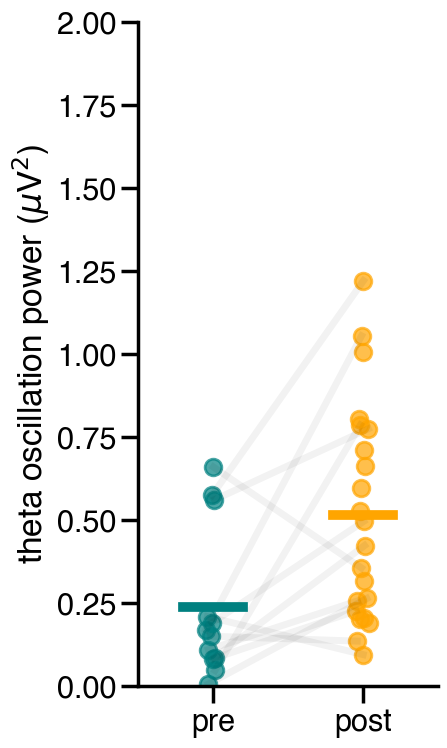

In [109]:
plot_feature_prepost(exp_df_mean, feature='theta_amp')
plt.ylabel('theta oscillation power ($\mu$V$^2$)')
plt.ylim(0, 2.0)
sns.despine()
plt.tight_layout()
plt.show()

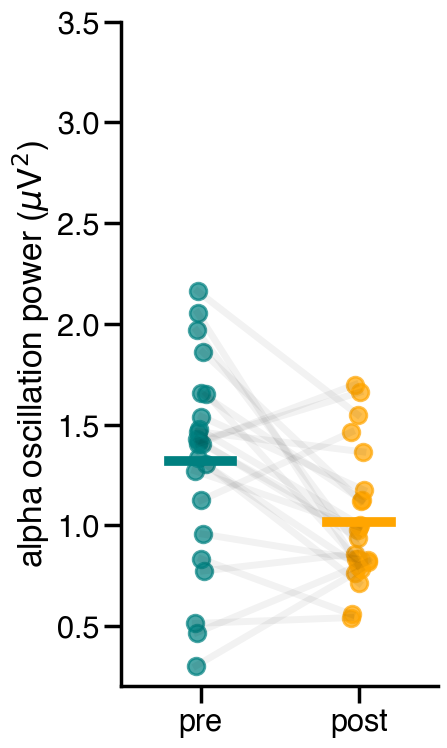

In [113]:
plot_feature_prepost(exp_df_mean, feature='alpha_amp')
plt.ylabel('alpha oscillation power ($\mu$V$^2$)')
plt.ylim(0.2, 3.5)
sns.despine()
plt.tight_layout()
plt.show()

## Power Spectra (specparam fits)

In [18]:
fits_pre_mean = np.nanmean(fits_pre_included, axis=1)
fits_post_mean = np.nanmean(fits_post_included, axis=1)

fits_pre_grand_mean = np.nanmean(fits_pre_included, axis=(0,1))
fits_post_grand_mean = np.nanmean(fits_post_included, axis=(0,1))

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_41957/1731462785.py:1: RuntimeWarning: Mean of empty slice
  fits_pre_mean = np.nanmean(fits_pre_included, axis=1)
/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_41957/1731462785.py:2: RuntimeWarning: Mean of empty slice
  fits_post_mean = np.nanmean(fits_post_included, axis=1)


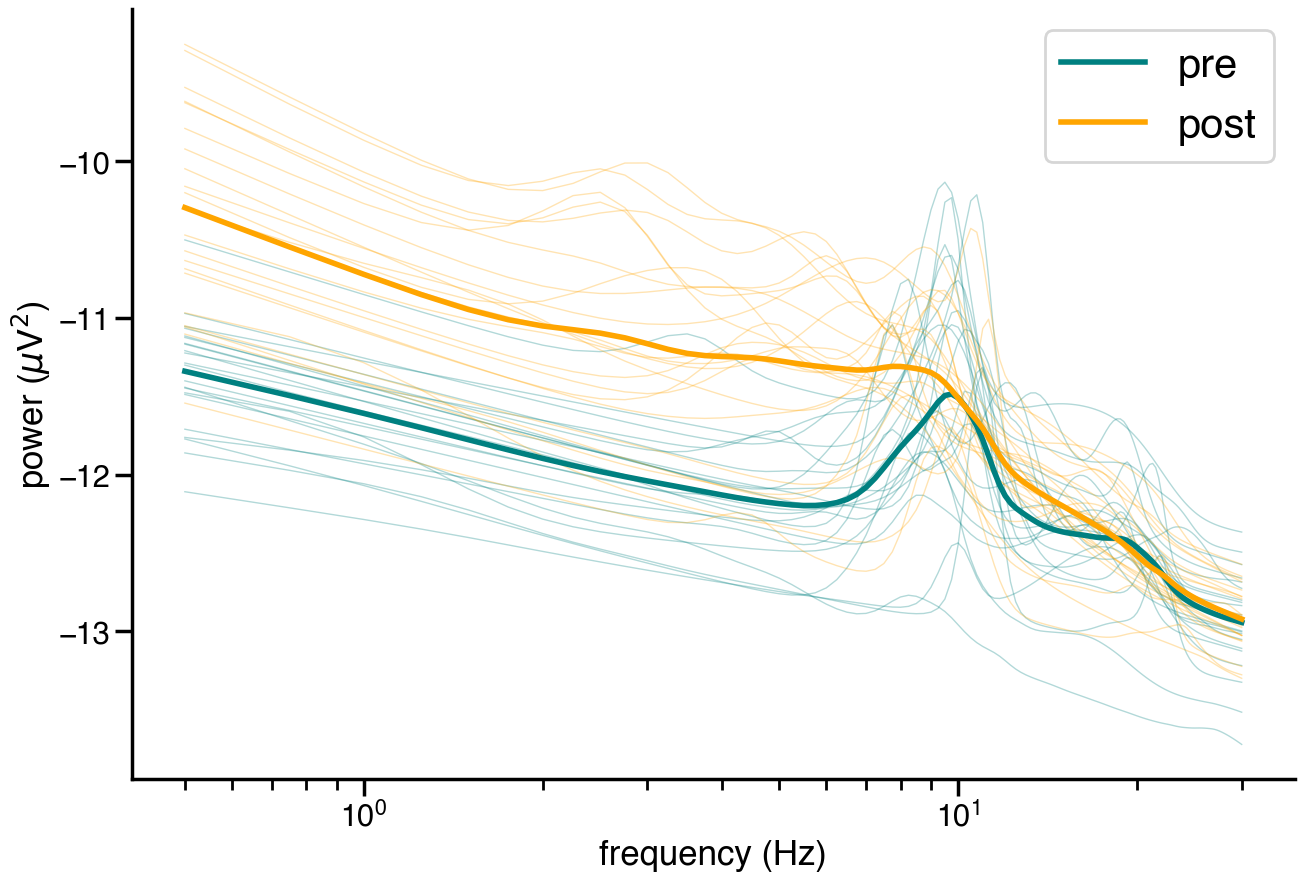

<Figure size 640x480 with 0 Axes>

In [19]:
sns.set_context('poster')
plt.figure(figsize=[15,10])

# plot patient pre
for patient in range(0, fits_pre_mean.shape[0]):
    plt.plot(freq_axis[2:121], fits_pre_mean[patient], color='teal', alpha = 0.3, linewidth = 1)

# plot patient post
for patient in range(0, fits_post_mean.shape[0]):
    plt.plot(freq_axis[2:121], fits_post_mean[patient], color='orange', alpha = 0.3, linewidth = 1)

# plot average pre
plt.plot(freq_axis[2:121], fits_pre_grand_mean, color='teal', linewidth = 4, label='pre')

# plot average post
plt.plot(freq_axis[2:121], fits_post_grand_mean, color='orange', linewidth = 4, label='post')


plt.xscale('log')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.ylabel("power ($\mu$V$^2$)", fontsize = 25)
plt.xlabel("frequency (Hz)", fontsize = 25)
plt.legend(prop = {'size': 30})

sns.despine()
plt.show()
plt.savefig(fig_path+'spectra_fits.pdf', format='pdf')

## Plot Spectra (raw PSDs)

In [20]:
psd_pre_mean = np.nanmean(psd_pre_included, axis=1)
psd_post_mean = np.nanmean(psd_post_included, axis=1)

psd_pre_grand_mean = np.nanmean(psd_pre_included, axis=(0,1))
psd_post_grand_mean = np.nanmean(psd_post_included, axis=(0,1))

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_41957/4288182120.py:1: RuntimeWarning: Mean of empty slice
  psd_pre_mean = np.nanmean(psd_pre_included, axis=1)
/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_41957/4288182120.py:2: RuntimeWarning: Mean of empty slice
  psd_post_mean = np.nanmean(psd_post_included, axis=1)


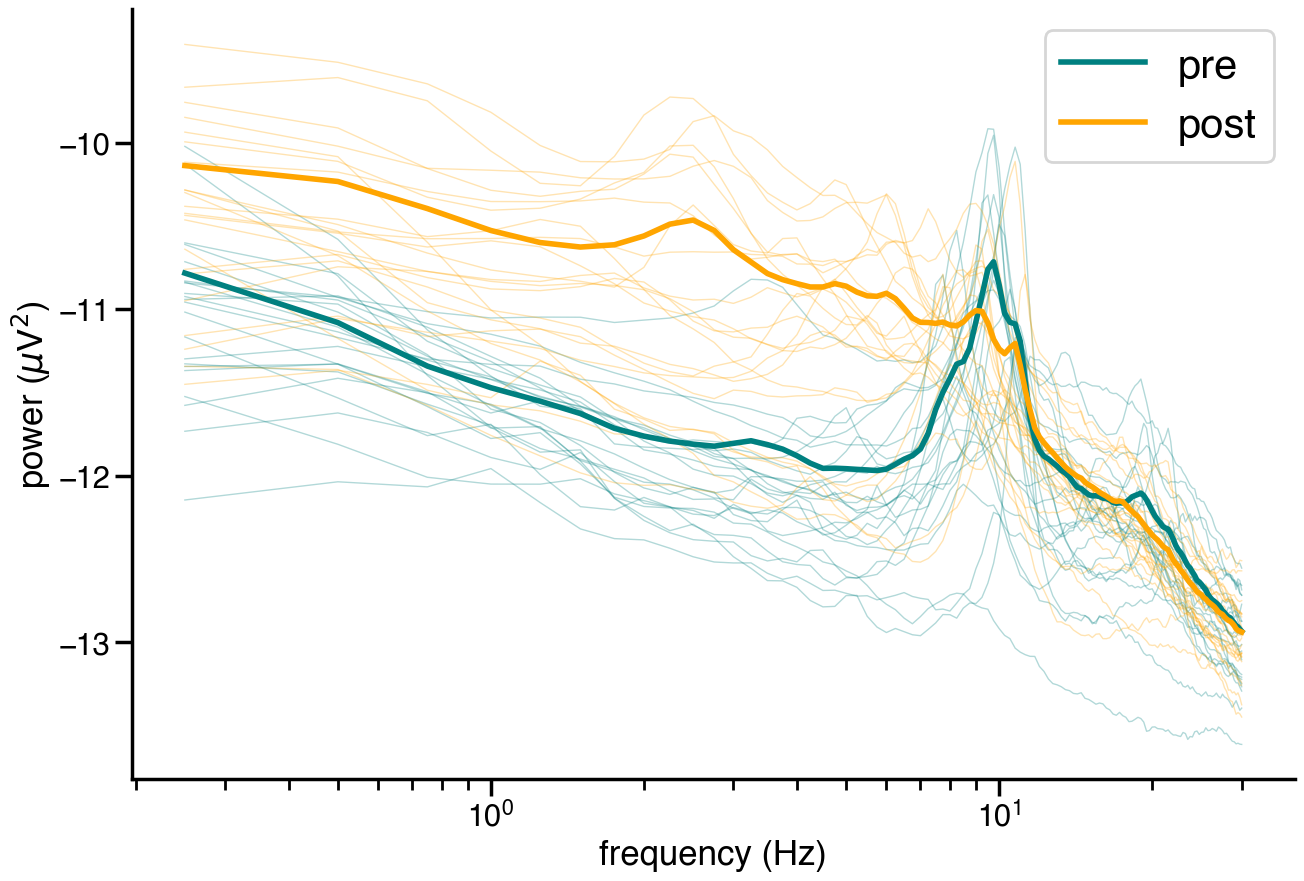

In [21]:
# plot patient pre

sns.set_context('poster')
plt.figure(figsize=[15,10])

for patient in range(0, psd_pre_mean.shape[0]):
    plt.plot(freq_axis[1:121], np.log10(psd_pre_mean[patient,1:121]), color='teal', alpha = 0.3, linewidth = 1)

# plot patient post
for patient in range(0, psd_post_mean.shape[0]):
    plt.plot(freq_axis[1:121], np.log10(psd_post_mean[patient,1:121]), color='orange', alpha = 0.3, linewidth = 1)

# plot average pre
plt.plot(freq_axis[1:121], np.log10(psd_pre_grand_mean[1:121]), color='teal', linewidth = 4, label='pre')

# plot average post
plt.plot(freq_axis[1:121], np.log10(psd_post_grand_mean[1:121]), color='orange', linewidth = 4, label='post')

plt.xscale('log')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.ylabel("power ($\mu$V$^2$)", fontsize = 25)
plt.xlabel("frequency (Hz)", fontsize = 25)
plt.legend(prop = {'size': 30})


sns.despine()

plt.show()

# Statistics

### Exponent: Pre/Post

**Normality**

In [22]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['exponent'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['exponent'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.975466  0.816483    True
          W      pval  normal
0  0.953387  0.343443    True


In [23]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: 0.87 std: 0.2
post: 1.42 std: 0.34


**Distribution of means pre vs. post**

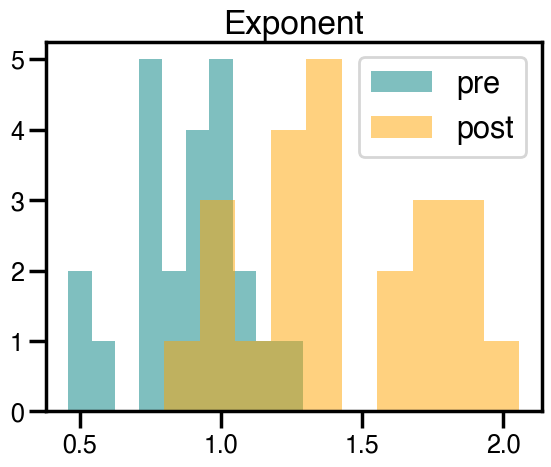

In [24]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Exponent')
plt.show()

**Wilcoxon Test**

In [25]:
print(wilcoxon(means_pre, means_post))

          W-val alternative         p-val  RBC      CLES
Wilcoxon    0.0   two-sided  2.384186e-07 -1.0  0.079395


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.07606 

               T  dof alternative         p-val           CI95%   cohen-d  \
T-test -8.981881   22   two-sided  8.202024e-09  [-0.68, -0.43]  1.924916   

             BF10  power  
T-test  1.538e+06    1.0  


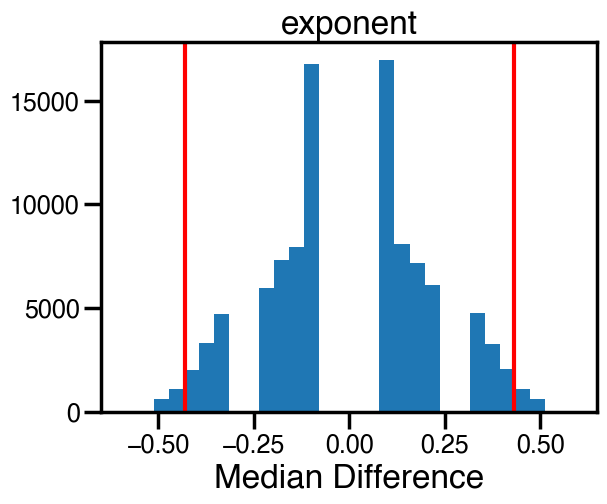

In [26]:
perm_test(exp_df_mean, feature='exponent')

### Offset: Pre/Post

**Normality**

In [27]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['offset'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['offset'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.961556  0.495496    True
          W      pval  normal
0  0.972236  0.742335    True


**Distribution of means pre vs. post**

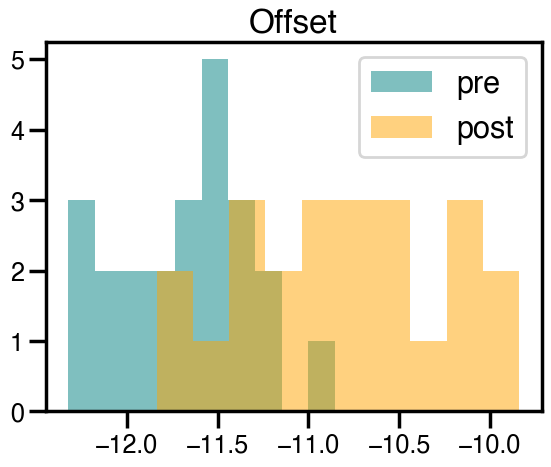

In [28]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Offset')
plt.show()

**Wilcoxon Test**

In [29]:
print(wilcoxon(means_pre, means_post))

          W-val alternative         p-val       RBC      CLES
Wilcoxon    2.0   two-sided  7.152557e-07 -0.985507  0.115312


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

               T  dof alternative         p-val           CI95%   cohen-d  \
T-test -9.289714   22   two-sided  4.533028e-09  [-1.05, -0.66]  1.768534   

             BF10  power  
T-test  2.676e+06    1.0  


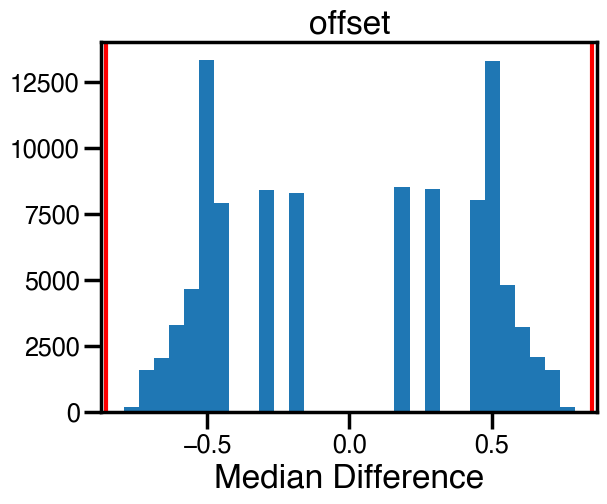

In [30]:
perm_test(exp_df_mean, feature='offset')

### Delta Oscillatory Power: Pre/Post

**Normality**

In [31]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_amp'].values # .dropna(how="any")
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['delta_amp'].values

# # normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.801968  0.009865   False
          W      pval  normal
0  0.927511  0.108887    True


In [32]:
means_pre

array([       nan, 0.11058374, 0.21000609, 0.08296138, 0.15126295,
              nan,        nan, 0.57514912, 0.66000903, 0.17053742,
       0.56148724,        nan, 0.19149019,        nan,        nan,
              nan, 0.08507729,        nan, 0.00723635,        nan,
       0.04810734,        nan,        nan])

In [33]:
means_post

array([       nan, 0.25711356, 0.09582457, 0.42394661, 0.13644046,
       0.71099455, 0.31614753, 1.22047541, 0.35657183, 1.05462038,
       0.7749575 , 0.66448679, 0.49679684, 0.20221186, 0.59560269,
       0.52859927, 0.22752755, 0.20522169, 0.264616  , 0.19144258,
       0.78635977, 0.8054272 , 1.00586402])

In [34]:
print('pre: ' + str(round(np.nanmean(means_pre),2)) + ' std: ' + str(round(np.nanstd(means_pre),2)))
print('post: ' + str(round(np.nanmean(means_post),2)) + ' std: ' + str(round(np.nanstd(means_post),2)))



pre: 0.24 std: 0.22
post: 0.51 std: 0.32


**Distribution of means pre vs. post**

This one is tricky to do stats for because the pre has so few channels that even detect a delta oscillation. When we try to keep the 0's instead of NaNs, the Wilcoxon test fails due to 'ties'. Therefore, we are keeping the NaNs, and will just report the permutation test for statistics.

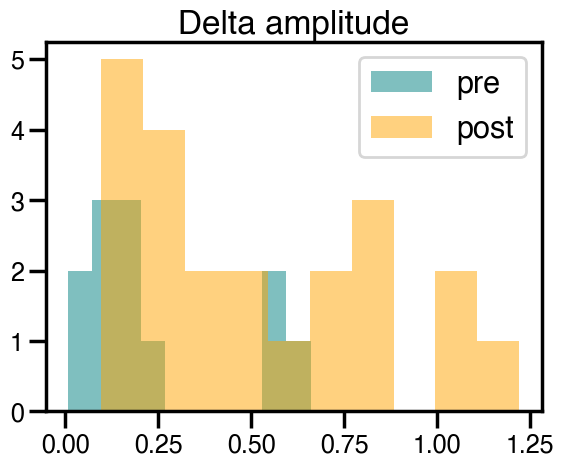

In [35]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta amplitude')
plt.show()

**Wilcoxon**

In [36]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val      RBC      CLES
Wilcoxon   10.0   two-sided  0.020996 -0.74359  0.229167


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

               T  dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test -2.684964   11   two-sided  0.021219  [-0.49, -0.05]  0.883045  3.235   

           power  
T-test  0.795051  


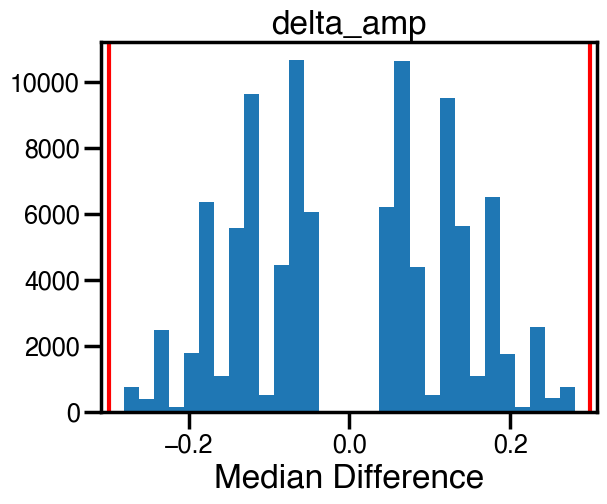

In [37]:
# this test can't be run because there's only one value
perm_test(exp_df_mean, feature='delta_amp')

### Delta Bandpower: Pre/Post

**Normality**

In [38]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_bp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['delta_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W     pval  normal
0  0.960429  0.47209    True
          W      pval  normal
0  0.967304  0.624764    True


In [39]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: -11.95 std: 0.32
post: -11.07 std: 0.6


#### Distribution of means pre vs. post

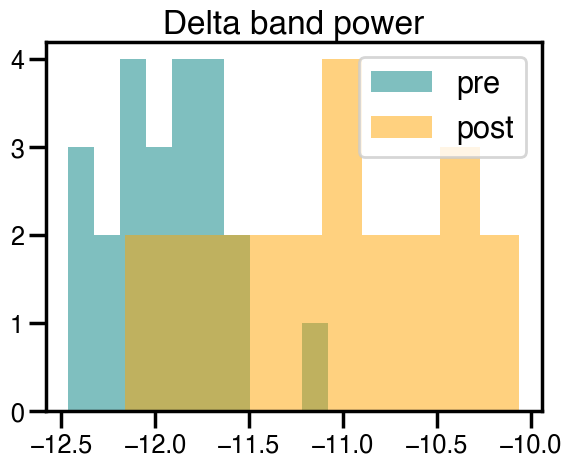

In [40]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta band power')
plt.show()

**Wilcoxon Test**

In [41]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC     CLES
Wilcoxon    3.0   two-sided  0.000001 -0.978261  0.10397


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

               T  dof alternative         p-val          CI95%   cohen-d  \
T-test -8.330341   22   two-sided  2.996010e-08  [-1.1, -0.66]  1.788767   

             BF10  power  
T-test  4.601e+05    1.0  


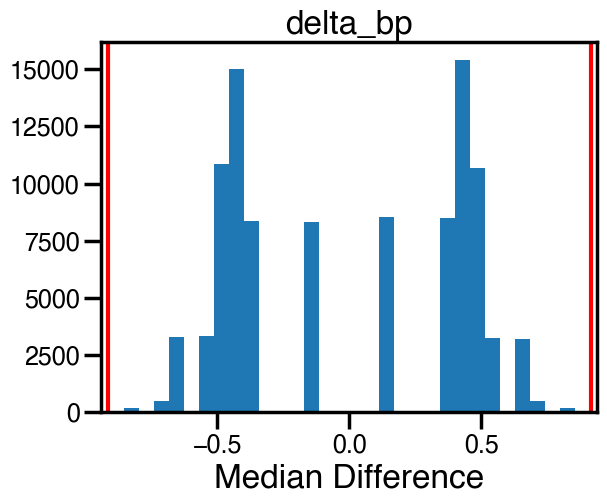

In [42]:
perm_test(exp_df_mean, feature='delta_bp')

### Delta Center Frequency: Pre/Post

**Normality**

In [43]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_cf'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['delta_cf'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W     pval  normal
0  0.941943  0.52365    True
          W      pval  normal
0  0.919951  0.075839    True


#### Distribution of means pre vs. post

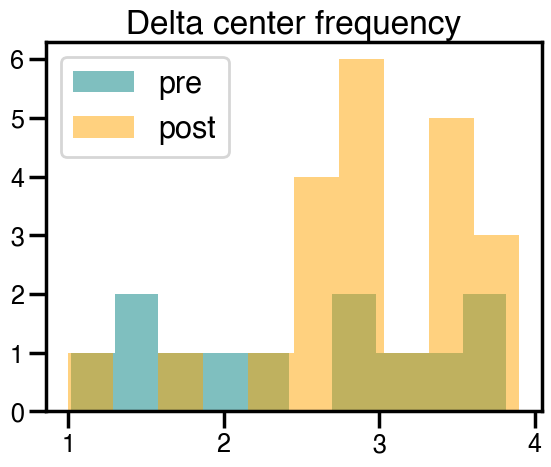

In [44]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta center frequency')
plt.show()

**Wilcoxon Test**

In [45]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   24.0   two-sided  0.266113 -0.384615  0.395833


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.34604 

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -1.215609   11   two-sided  0.249579  [-1.01, 0.29]  0.418186  0.527   

           power  
T-test  0.262861  


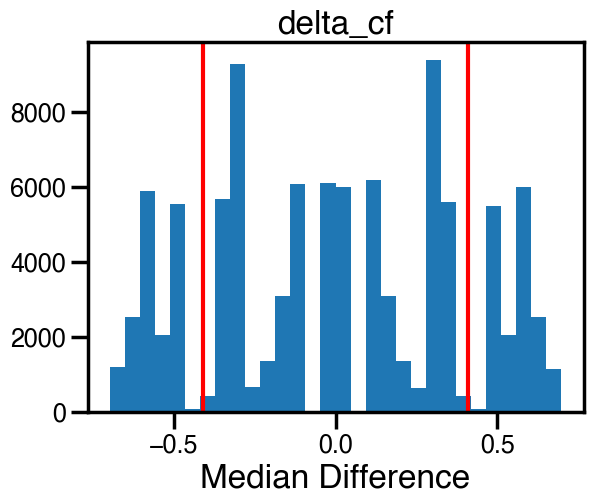

In [46]:
perm_test(exp_df_mean, feature='delta_cf')

### Theta Oscillatory Power: Pre/Post

**Normality**

In [47]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_amp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['theta_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.937012  0.210424    True
          W      pval  normal
0  0.958549  0.460518    True


In [48]:
print('pre: ' + str(round(np.nanmean(means_pre),2)) + ' std: ' + str(round(np.nanstd(means_pre),2)))
print('post: ' + str(round(np.nanmean(means_post),2)) + ' std: ' + str(round(np.nanstd(means_post),2)))

pre: 0.3 std: 0.15
post: 0.7 std: 0.31


#### Distribution of means pre vs. post

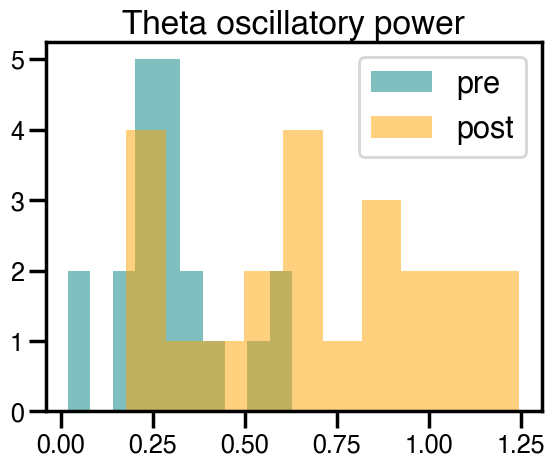

In [49]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Theta oscillatory power')
plt.show()

**Wilcoxon Test**

In [50]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC   CLES
Wilcoxon    9.0   two-sided  0.000063 -0.914286  0.165


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

               T  dof alternative     p-val           CI95%   cohen-d  \
T-test -5.654971   19   two-sided  0.000019  [-0.56, -0.26]  1.555729   

            BF10  power  
T-test  1244.326    1.0  


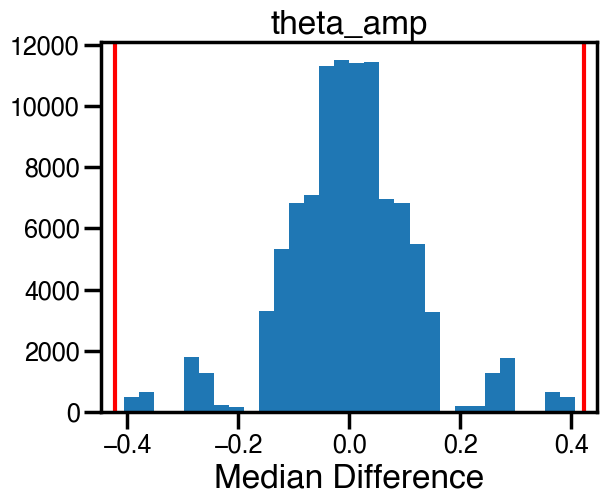

In [51]:
perm_test(exp_df_mean, feature='theta_amp')

### Theta Bandpower: Pre/Post

**Normality**

In [52]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_bp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['theta_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W     pval  normal
0  0.975869  0.82528    True
          W      pval  normal
0  0.930059  0.109685    True


In [53]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: -12.2 std: 0.41
post: -11.28 std: 0.59


#### Distribution of means pre vs. post

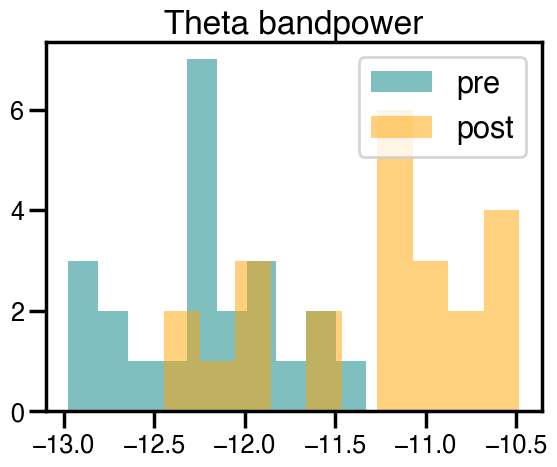

In [54]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Theta bandpower')
plt.show()

**Wilcoxon Test**

In [55]:
print(wilcoxon(means_pre, means_post))

          W-val alternative         p-val       RBC      CLES
Wilcoxon    1.0   two-sided  4.768372e-07 -0.992754  0.119093


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

               T  dof alternative         p-val           CI95%   cohen-d  \
T-test -8.905377   22   two-sided  9.522271e-09  [-1.14, -0.71]  1.777789   

             BF10  power  
T-test  1.338e+06    1.0  


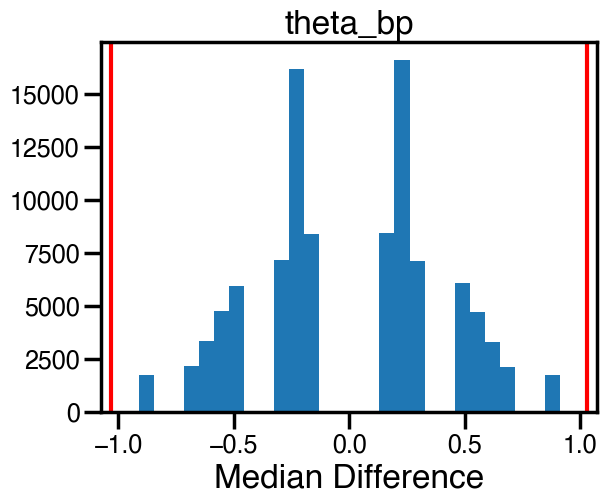

In [56]:
perm_test(exp_df_mean, feature='theta_bp')

### Theta Center Frequency: Pre/Post

**Normality**

In [57]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_cf'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['theta_cf'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.943561  0.279716    True
          W      pval  normal
0  0.950212  0.318912    True


#### Distribution of means pre vs. post

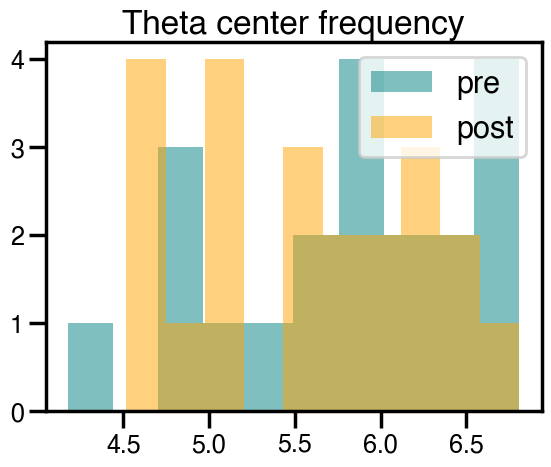

In [58]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Theta center frequency')
plt.show()

**Wilcoxon Test**

In [59]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC   CLES
Wilcoxon   69.0   two-sided  0.189348  0.342857  0.615


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.39551000000000003 

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  1.356386   19   two-sided  0.190877  [-0.15, 0.71]  0.382765  0.515   

           power  
T-test  0.369154  


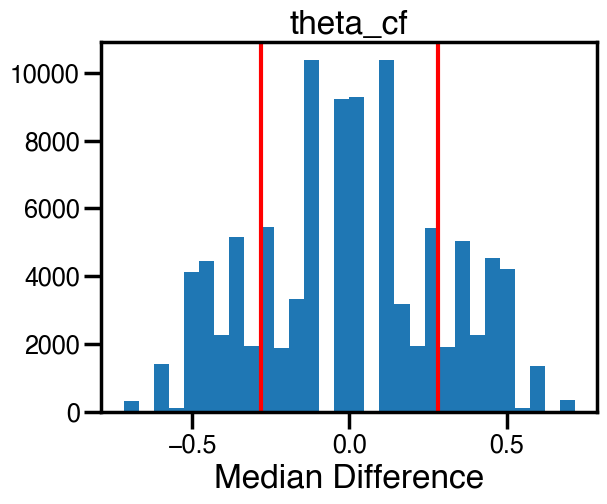

In [60]:
perm_test(exp_df_mean, feature='theta_cf')

### Alpha Oscillatory Power: Pre/Post

**Normality**

In [61]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_amp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.957617  0.416978    True
          W      pval  normal
0  0.912334  0.045751   False


In [62]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: 1.32 std: 0.49
post: 1.02 std: 0.32


#### Distribution of means pre vs. post

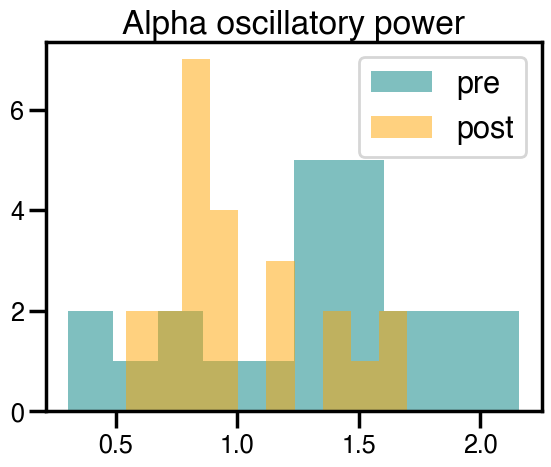

In [63]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha oscillatory power')
plt.show()

**Wilcoxon Test**

In [64]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   48.0   two-sided  0.004851  0.652174  0.689981


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

               T  dof alternative     p-val        CI95%  cohen-d   BF10  \
T-test  3.083093   22   two-sided  0.005436  [0.1, 0.51]   0.7171  8.212   

           power  
T-test  0.907505  


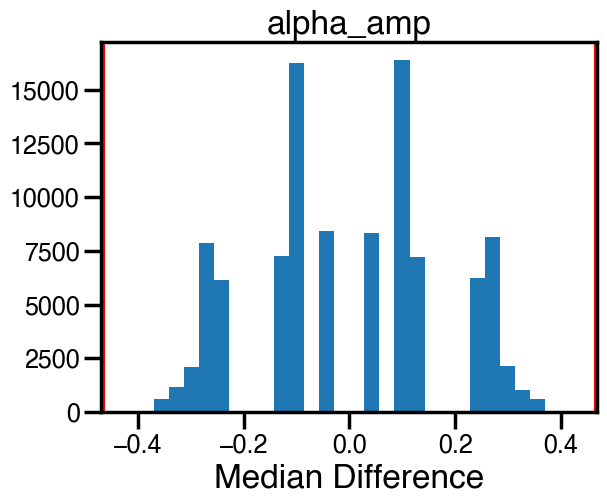

In [65]:
perm_test(exp_df_mean, feature='alpha_amp')

### Alpha Bandpower: Pre/Post

**Normality**

In [66]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_bp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.978607  0.881128    True
          W      pval  normal
0  0.974123  0.786315    True


In [67]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: -11.6 std: 0.58
post: -11.38 std: 0.36


#### Distribution of means pre vs. post

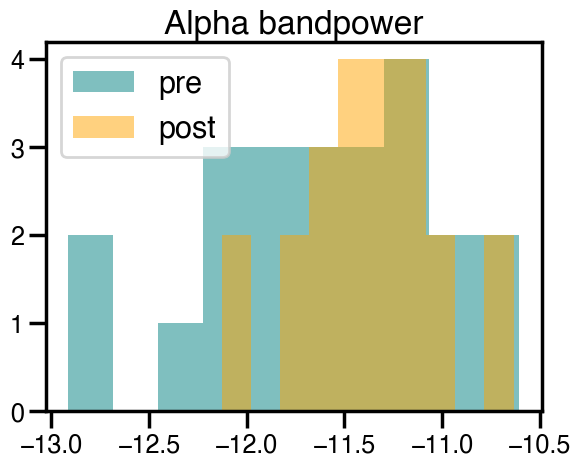

In [68]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha bandpower')
plt.show()

**Wilcoxon Test**

In [69]:
print(wilcoxon(means_pre, means_post))

          W-val alternative    p-val       RBC      CLES
Wilcoxon   68.0   two-sided  0.03267 -0.507246  0.389414


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

               T  dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test -2.338097   22   two-sided  0.028878  [-0.42, -0.03]  0.455536  2.047   

           power  
T-test  0.551283  


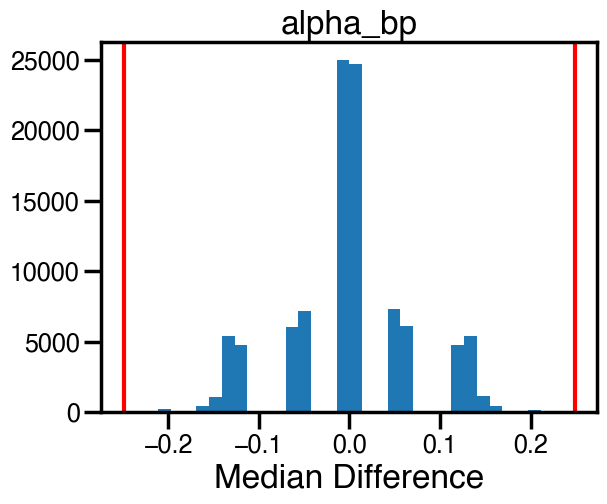

In [70]:
perm_test(exp_df_mean, feature='alpha_bp')

### Alpha Center Frequency: Pre/Post

**Normality**

In [71]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_cf'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_cf'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.965818  0.590042    True
          W      pval  normal
0  0.955926  0.386225    True




#### Distribution of means pre vs. post

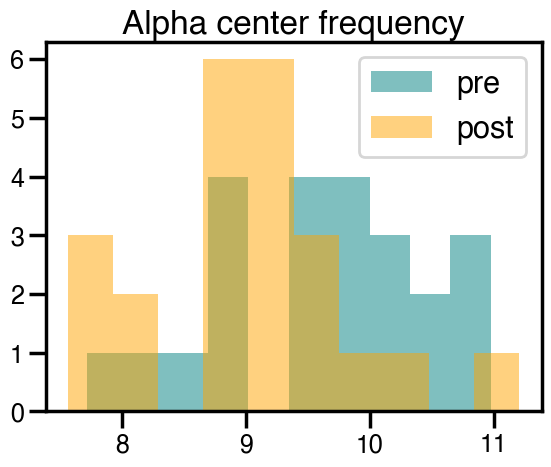

In [72]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha center frequency')
plt.show()

**Wilcoxon Test**

In [73]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC     CLES
Wilcoxon   28.0   two-sided  0.000349  0.797101  0.68431


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.00045 

               T  dof alternative     p-val        CI95%   cohen-d     BF10  \
T-test  4.441768   22   two-sided  0.000205  [0.29, 0.8]  0.641727  143.519   

          power  
T-test  0.83668  


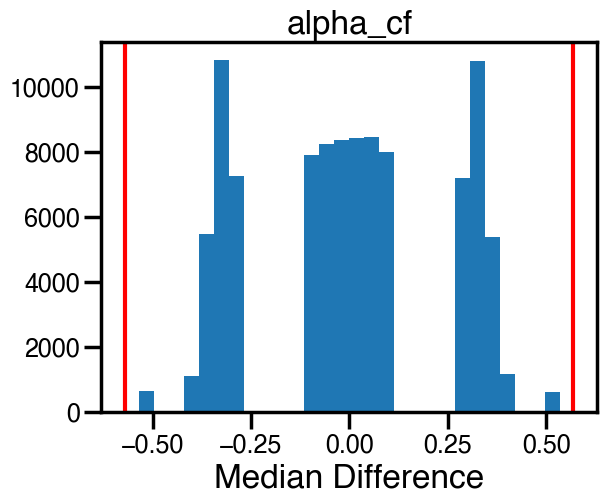

In [74]:
perm_test(exp_df_mean, feature='alpha_cf')

## Presence/Absence/Percentage of Channels with Oscillations

We are determining what % of channels have a delta/theta/alpha oscillation per participant, per pre/post

### Delta Percentage

In [75]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have a delta oscillation)

features = ['patient','pre_post','channel','delta_cf']
exp_df_delta_osc = exp_df_included[features]
exp_df_delta_osc['delta_present'] = exp_df_delta_osc['delta_cf'].notna()

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_41957/259686611.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_delta_osc['delta_present'] = exp_df_delta_osc['delta_cf'].notna()


In [76]:
# With this new df, we want to group by the patient/pre_post to show how many channels have a delta oscillation
# Also need to calculate the total # of channels b/c need to get a percentage 
# (not all pts have same # of channels due to exclusion criteria)

ch_delta = exp_df_delta_osc.groupby(['patient', 'pre_post'])['delta_present'].sum().values
ch_total = exp_df_delta_osc.groupby(['patient', 'pre_post'])['channel'].count().values

ch_delta_perc = ch_delta/ch_total

In [77]:
# Add the delta oscillation percentages to the other df to determine which value corresponds to pre/post

delta_osc_perc = pd.DataFrame(exp_df_delta_osc.groupby(['patient', 'pre_post'], as_index=False)['delta_present'].sum())
delta_osc_perc['ch_delta_perc'] = ch_delta_perc


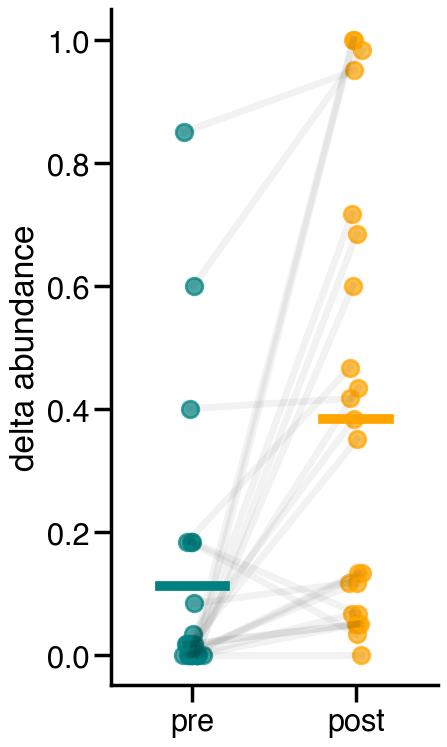

In [78]:
plot_feature_prepost(delta_osc_perc, feature='ch_delta_perc')
plt.ylabel('delta abundance')
plt.tight_layout()
sns.despine()
plt.show()

**Normality**

In [79]:
perc_delta_pre = delta_osc_perc[delta_osc_perc['pre_post']=='pre']['ch_delta_perc'].values
perc_delta_post = delta_osc_perc[delta_osc_perc['pre_post']=='post']['ch_delta_perc'].values

# normality test
print(normality(perc_delta_pre, method='shapiro'))
print(normality(perc_delta_post, method='shapiro'))

          W          pval  normal
0  0.589064  6.860150e-07   False
          W      pval  normal
0  0.851126  0.002852   False


In [80]:
print('pre: ' + str(round(perc_delta_pre.mean(),2)) + ' std: ' + str(round(perc_delta_pre.std(),2)))
print('post: ' + str(round(perc_delta_post.mean(),2)) + ' std: ' + str(round(perc_delta_post.std(),2)))

pre: 0.11 std: 0.21
post: 0.38 std: 0.35


**Wilcoxon Test**

In [81]:
print(wilcoxon(perc_delta_pre, perc_delta_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   20.0   two-sided  0.000576 -0.841897  0.188091


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

               T  dof alternative     p-val           CI95%   cohen-d    BF10  \
T-test -3.939732   22   two-sided  0.000699  [-0.41, -0.13]  0.915618  48.525   

          power  
T-test  0.98721  


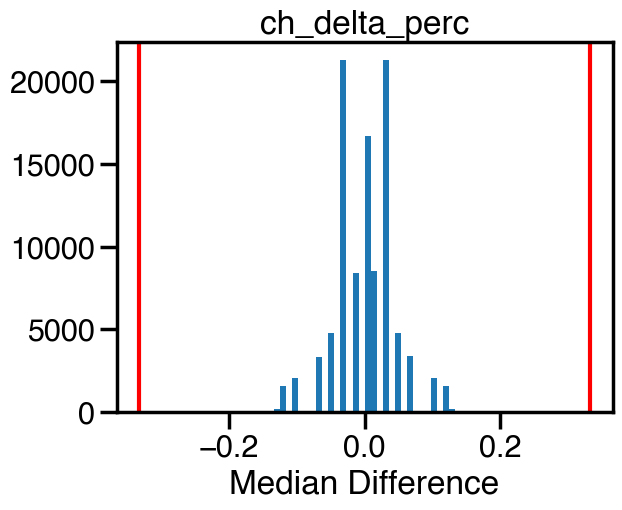

In [82]:
perm_test(delta_osc_perc, feature='ch_delta_perc')

### Theta Percentage

In [83]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have a theta oscillation)

features = ['patient','pre_post','channel','theta_cf']
exp_df_theta_osc = exp_df_included[features]
exp_df_theta_osc['theta_present'] = exp_df_theta_osc['theta_cf'].notna()

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_41957/2939216184.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_theta_osc['theta_present'] = exp_df_theta_osc['theta_cf'].notna()


In [84]:
# With this new df, we want to group by the patient/pre_post to show how many channels have a theta oscillation
# Also need to calculate the total # of channels b/c need to get a percentage 
# (not all pts have same # of channels due to exclusion criteria)

ch_theta = exp_df_theta_osc.groupby(['patient', 'pre_post'])['theta_present'].sum().values
ch_total = exp_df_theta_osc.groupby(['patient', 'pre_post'])['channel'].count().values

ch_theta_perc = ch_theta/ch_total

In [85]:
# Add the theta oscillation percentages to the other df to determine which value corresponds to pre/post

theta_osc_perc = pd.DataFrame(exp_df_theta_osc.groupby(['patient', 'pre_post'], as_index=False)['theta_present'].sum())
theta_osc_perc['ch_theta_perc'] = ch_theta_perc

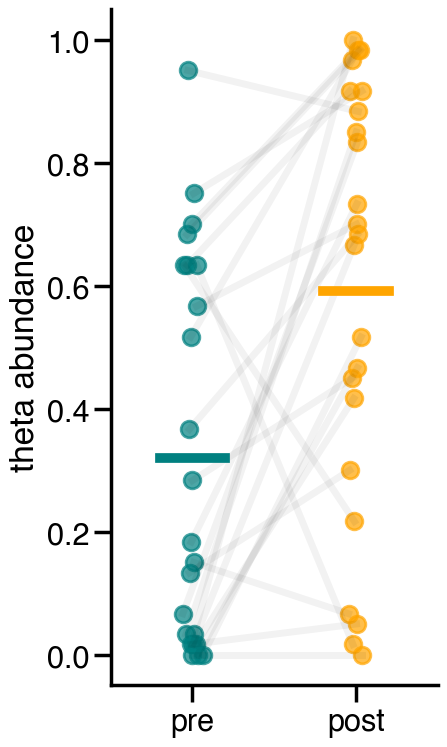

In [86]:
plot_feature_prepost(theta_osc_perc, feature='ch_theta_perc')
plt.ylabel('theta abundance')
sns.despine()
plt.tight_layout()
plt.show()

In [87]:
perc_theta_pre = theta_osc_perc[theta_osc_perc['pre_post']=='pre']['ch_theta_perc'].values
perc_theta_post = theta_osc_perc[theta_osc_perc['pre_post']=='post']['ch_theta_perc'].values

In [88]:
print('pre: ' + str(round(perc_theta_pre.mean(),2)) + ' std: ' + str(round(perc_theta_pre.std(),2)))
print('post: ' + str(round(perc_theta_post.mean(),2)) + ' std: ' + str(round(perc_theta_post.std(),2)))

pre: 0.32 std: 0.31
post: 0.59 std: 0.34


**Wilcoxon Test**

In [89]:
print(wilcoxon(perc_theta_pre, perc_theta_post))
print(normality(perc_theta_pre, method='shapiro'))
print(normality(perc_theta_post, method = 'shapiro'))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   36.0   two-sided  0.003477 -0.715415  0.270321
          W      pval  normal
0  0.855557  0.003437   False
          W      pval  normal
0  0.895283  0.020235   False


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

               T  dof alternative     p-val           CI95%   cohen-d    BF10  \
T-test -3.482224   22   two-sided  0.002112  [-0.43, -0.11]  0.824555  18.482   

           power  
T-test  0.965362  


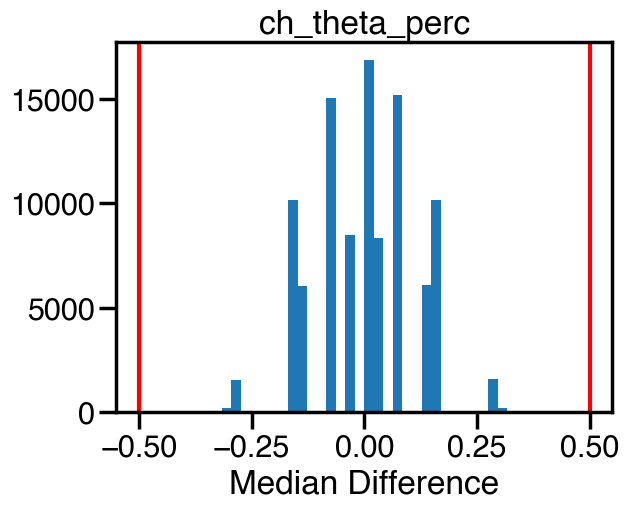

In [90]:
perm_test(theta_osc_perc, feature='ch_theta_perc')

### Alpha Percentage

In [91]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have an alpha oscillation)

features = ['patient','pre_post','channel','alpha_cf']
exp_df_alpha_osc = exp_df_included[features]
exp_df_alpha_osc['alpha_present'] = exp_df_alpha_osc['alpha_cf'].notna()

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_41957/4032763983.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_alpha_osc['alpha_present'] = exp_df_alpha_osc['alpha_cf'].notna()


In [92]:
# With this new df, we want to group by the patient/pre_post to show how many channels have a theta oscillation
# Also need to calculate the total # of channels b/c need to get a percentage 
# (not all pts have same # of channels due to exclusion criteria)

ch_alpha = exp_df_alpha_osc.groupby(['patient', 'pre_post'])['alpha_present'].sum().values
ch_total = exp_df_alpha_osc.groupby(['patient', 'pre_post'])['channel'].count().values

ch_alpha_perc = ch_alpha/ch_total

In [93]:
# Add the alpha oscillation percentages to the other df to determine which value corresponds to pre/post

alpha_osc_perc = pd.DataFrame(exp_df_alpha_osc.groupby(['patient', 'pre_post'], as_index=False)['alpha_present'].sum())
alpha_osc_perc['ch_alpha_perc'] = ch_alpha_perc

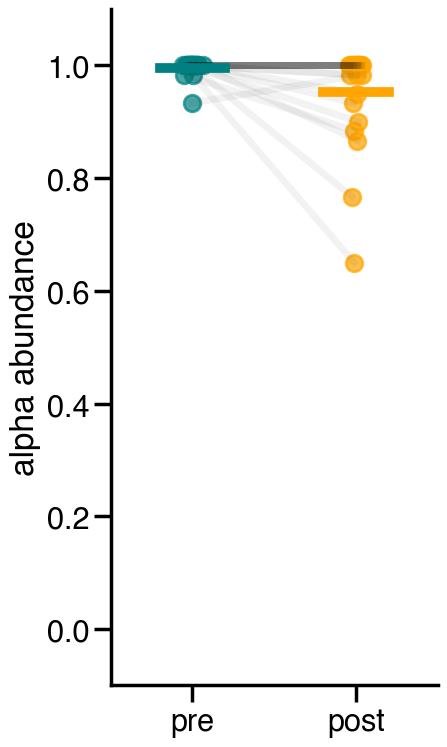

In [94]:
plot_feature_prepost(alpha_osc_perc, feature='ch_alpha_perc')
plt.ylabel('alpha abundance')
plt.ylim([-0.1,1.1])
sns.despine()
plt.tight_layout()
plt.show()

In [95]:
perc_alpha_pre = alpha_osc_perc[alpha_osc_perc['pre_post']=='pre']['ch_alpha_perc'].values
perc_alpha_post = alpha_osc_perc[alpha_osc_perc['pre_post']=='post']['ch_alpha_perc'].values

In [96]:
print('pre: ' + str(round(perc_alpha_pre.mean(),2)) + ' std: ' + str(round(perc_alpha_pre.std(),2)))
print('post: ' + str(round(perc_alpha_post.mean(),2)) + ' std: ' + str(round(perc_alpha_post.std(),2)))

pre: 1.0 std: 0.01
post: 0.95 std: 0.09


**Wilcoxon Test**

In [97]:
print(wilcoxon(perc_alpha_pre, perc_alpha_post))
print(normality(perc_alpha_pre, method='shapiro'))
print(normality(perc_alpha_post, method='shapiro'))

          W-val alternative     p-val       RBC      CLES
Wilcoxon    3.0   two-sided  0.014306  0.890909  0.666352
          W          pval  normal
0  0.346013  3.873517e-09   False
          W      pval  normal
0  0.621485  0.000002   False


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


**Permutation Test & T-Test**

The probability from the sampling statistics is =  2.0 

               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  2.373057   22   two-sided  0.026801  [0.01, 0.08]  0.683449  2.175   

           power  
T-test  0.879341  


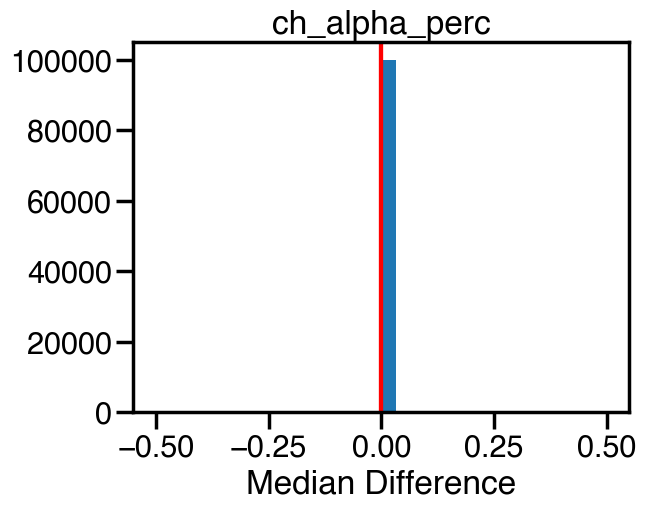

In [98]:
perm_test(alpha_osc_perc, feature='ch_alpha_perc')

## Merge Percentage Oscillation Dataframes

In [99]:
# merge percentage dfs
perc_df = pd.merge(theta_osc_perc, delta_osc_perc, how='outer', on=['patient', 'pre_post'])
perc_df = pd.merge(perc_df, alpha_osc_perc, how='outer', on=['patient', 'pre_post'])

In [100]:
# merge perc with main eeg feature df
exp_df_mean_wperc = pd.merge(exp_df_mean, perc_df, how='outer', on=['patient', 'pre_post'])

In [101]:
exp_df_mean_wperc.head()

,patient,pre_post,exponent,offset,delta_amp,delta_bp,theta_amp,theta_bp,theta_cf,delta_cf,alpha_amp,alpha_bp,alpha_bw,alpha_cf,theta_present,ch_theta_perc,delta_present,ch_delta_perc,alpha_present,ch_alpha_perc
0,2,post,0.958523,-11.593972,NaN,-11.961991,0.590210,-11.903487,6.342835,NaN,1.659774,-11.218859,1.731746,8.769562,31,0.516667,0,0.000000,60,1.000000
1,2,pre,0.757163,-12.180958,NaN,-12.400416,NaN,-12.811902,NaN,NaN,1.418996,-11.930311,1.729442,8.728769,0,0.000000,0,0.000000,60,1.000000
2,3,post,1.396966,-10.728465,0.257114,-11.024550,0.657874,-11.177237,6.156632,2.809696,0.557219,-11.589878,2.764398,9.954654,55,0.916667,28,0.466667,59,0.983333
3,3,pre,0.475478,-11.985471,0.110584,-12.143266,0.283711,-12.224720,6.654823,1.438948,0.832821,-11.876280,1.582728,10.035655,38,0.633333,11,0.183333,60,1.000000
4,4,post,0.976076,-11.836341,0.095825,-12.158437,0.272331,-12.391280,4.576834,2.845098,0.999776,-12.115812,1.617807,9.229187,51,0.850000,3,0.050000,60,1.000000


## Multiple Regression Spectral Analysis

What EEG features may be predictive of other EEG features? Specifically, what might be driving the bandpower differences pre vs. post?

### Using Treatment Difference

**Take difference of pre - post**

In [102]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_cf', 'ch_theta_perc', 'ch_delta_perc', 'ch_alpha_perc']


diff_df_mean_wperc = exp_df_mean_wperc.groupby(['patient'], as_index=False)[features].diff().dropna(0, how='all')
diff_df_mean_wperc['patient'] = exp_df_mean_wperc['patient']

diff_df_mean_wperc

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_41957/1529135655.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  diff_df_mean_wperc = exp_df_mean_wperc.groupby(['patient'], as_index=False)[features].diff().dropna(0, how='all')


,exponent,offset,delta_amp,delta_bp,theta_amp,theta_bp,theta_cf,delta_cf,alpha_amp,alpha_bp,alpha_cf,ch_theta_perc,ch_delta_perc,ch_alpha_perc,patient
1,-0.201360,-0.586986,NaN,-0.438425,NaN,-0.908415,NaN,NaN,-0.240777,-0.711451,-0.040793,-0.516667,0.000000,0.000000,2
3,-0.921488,-1.257006,-0.146530,-1.118715,-0.374163,-1.047483,0.498191,-1.370748,0.275602,-0.286402,0.081001,-0.283333,-0.283333,0.016667,3
5,-0.165961,0.295766,0.114182,0.405595,0.017846,0.160953,0.728374,-0.457869,0.476360,0.772309,0.813720,-0.816667,-0.033333,0.000000,4
7,-0.353966,-0.580045,-0.340985,-0.642551,-0.702215,-1.067190,0.864910,-0.117734,-0.338883,-0.726749,1.695906,-0.283333,0.116667,0.000000,10
9,-0.081453,-0.172336,0.014822,-0.164490,-0.047091,-0.212238,-0.287061,-0.143926,0.100156,-0.051523,0.028742,-0.166667,-0.016667,0.000000,13
11,-0.495305,-0.712337,NaN,-0.799572,-0.631210,-1.106876,0.826101,NaN,0.124481,-0.211126,1.022782,-0.316667,-0.133333,0.000000,16
13,-0.451485,-0.656820,NaN,-0.634137,NaN,-0.899623,NaN,NaN,-0.351969,-0.668322,0.645290,-0.466667,-0.050000,0.133333,18
15,-0.083357,-0.509437,-0.645326,-0.510974,-0.183102,-0.532039,-0.479380,0.584501,0.816547,0.059345,1.240010,-0.033333,0.150000,0.016667,19
17,-0.654239,-1.448017,0.303437,-1.377990,-0.412253,-1.561881,0.705843,-1.575370,-0.029161,-1.113722,1.121860,-0.650000,-0.350000,0.333333,25
19,-0.431640,-1.109276,-0.884083,-1.454383,-0.686755,-1.644640,-1.199892,-0.736019,-0.462284,-1.134528,1.133505,0.416667,-0.100000,0.100000,29


In [103]:
# multiple linear regression to see where changes in delta & theta come from
model = ols('delta_bp ~ exponent + delta_amp + ch_delta_perc', diff_df_mean_wperc).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               delta_bp   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     7.238
Date:                Tue, 20 Jun 2023   Prob (F-statistic):             0.0114
Time:                        15:39:38   Log-Likelihood:                -2.5338
No. Observations:                  12   AIC:                             13.07
Df Residuals:                       8   BIC:                             15.01
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0490      0.234      0.209

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [104]:
model = ols('theta_bp ~ exponent + theta_amp + ch_theta_perc', diff_df_mean_wperc).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               theta_bp   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     18.80
Date:                Tue, 20 Jun 2023   Prob (F-statistic):           1.70e-05
Time:                        15:39:38   Log-Likelihood:                0.15379
No. Observations:                  20   AIC:                             7.692
Df Residuals:                      16   BIC:                             11.68
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.1900      0.139     -1.372

In [105]:
model = ols('alpha_bp ~ exponent + alpha_amp + ch_alpha_perc', diff_df_mean_wperc).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               alpha_bp   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     8.533
Date:                Tue, 20 Jun 2023   Prob (F-statistic):           0.000854
Time:                        15:39:38   Log-Likelihood:                -4.3903
No. Observations:                  23   AIC:                             16.78
Df Residuals:                      19   BIC:                             21.32
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.2474      0.145     -1.704

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ch_theta_perc', ylabel='theta_bp'>

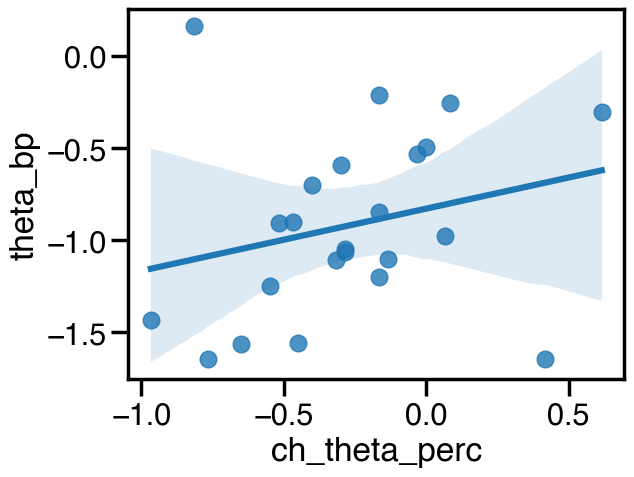

In [106]:
sns.regplot(diff_df_mean_wperc['ch_theta_perc'], diff_df_mean_wperc['theta_bp'])

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='offset', ylabel='theta_bp'>

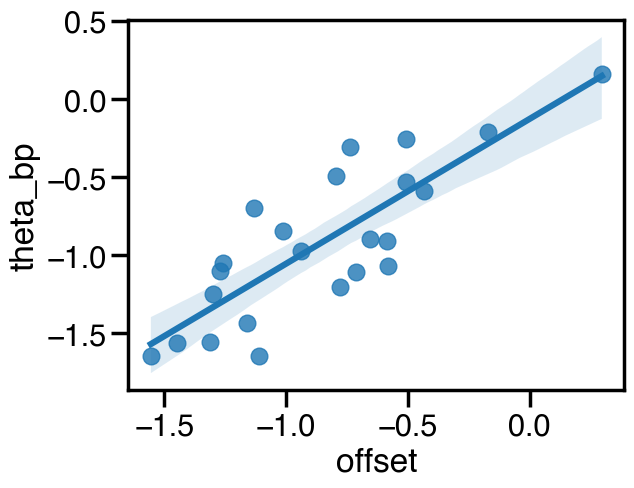

In [107]:
sns.regplot(diff_df_mean_wperc['offset'], diff_df_mean_wperc['theta_bp'])

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent', ylabel='theta_bp'>

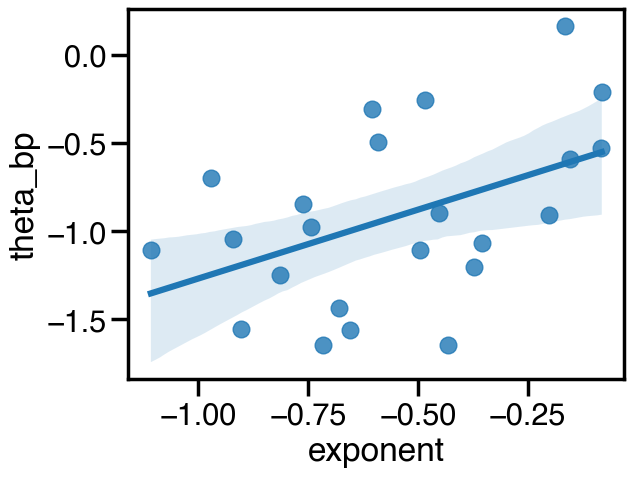

In [108]:
sns.regplot(diff_df_mean_wperc['exponent'], diff_df_mean_wperc['theta_bp'])